#Задание Pro

В одной из баз: hh или квартир, сделайте callback, который будет выводить на каждой эпохе следующее:

1. Текущую mae.    (ГОТОВО)
2. График mae по всем эпохам на обучающей и проверочной выборках.   (ГОТОВО)
3. Текущий scatterplot, где отображаются предсказанные и истинные значения. (ГОТОВО)
4. Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения. (ГОТОВО)
5. Изменял бы шаг обучения, если начинается “пила” на графике ошибки (mae), или график выходит на плато. (ГОТОВО)
6. Сохраняет сеть с лучшей точностью в .h5 файл.  (ГОТОВО)
*желательно использовать clear_output и verbose=0

**callback должен быть самописный, нельзя использовать готовые

# Загрузка библиотек и данных

In [1]:
from tensorflow.keras.callbacks import Callback     # Для кастомных коллбеков
import time

import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler # 
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 
import math # Для округления
#import os #Для работы с файлами 
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

In [2]:
!rm -rf *      # Удаление всех каталогов и файлов в текущей директории

In [3]:
# Загрузил исходные данные к себе на диск и запаковал, чтобы меньше занимали, поэтому файл zip

import gdown
gdown.download('https://drive.google.com/uc?id=1bnBcknAtCM6qE7O0XQif_NLa9Ma9pYfR', 'moscow.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bnBcknAtCM6qE7O0XQif_NLa9Ma9pYfR
To: /content/moscow.zip
100%|██████████| 33.4M/33.4M [00:00<00:00, 98.2MB/s]


'moscow.zip'

In [4]:
!unzip -q -O utf-8 '/content/moscow.zip' -d '/content'      # Распаковаываем базу

!rm 'moscow.zip'             # Удаляем файл архива после распаковки.   

In [5]:
df = pd.read_csv('/content/moscow.csv', sep=";")    #Загружаем данные в data frame

# Предварительная подготовка данных

In [6]:
df.head(6)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
3,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
5,Для заметок:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df = df.iloc[::2][:]  # Убираем из дата-фрейма каждую вторую строчку (так как там всякий мусор)

In [8]:
df.shape

(126268, 14)

In [9]:
df.head(6)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...
10,1,Шелепиха м.,15п,9/36 К,NaN,NaN,44/14.7/19.2,12700000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,"1-комн. квартира в ЖК ""Сердце столицы"" на 9 эт..."


In [10]:
data = df.values #Вытаскиваем данные в numpy array
type(data)

numpy.ndarray

In [11]:
print(df.columns) #Показываем имена колонок данных
#Мы будем использовать

#В xTrain - база числовых значени
#Комнат
#Метро / ЖД станции
#От станции
#Дом
#Балкон
#Санузел
#Площадь

#В xTrainC - база текстов о квартирах
#Примечание

#В yTrain
#Цена, руб.

#Остальные колонки игнорируем

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


# Функции парсинга

In [12]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1

#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Еcть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0
  
  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 

        if (int(floorStr) == int(floorsStr)): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

#Получаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

# Формируем обучащую выборку

In [13]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [14]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

In [15]:
print(yTrain.shape)
print(xTrain.shape)

(62504,)
(62504, 109)


# Парсинг текста

In [16]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")# удаляем лишние символы
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр
  
  
  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами
  
  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словая
  for word in words:
    
    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре
    
    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

#Собираем xTrainC по текстам

In [17]:
xTrainC, allTextComments = getXTrainComments(data1) #Создаём обучающую выборку по текстам и большо текст для словаря
allWords = text2Words(allTextComments) #Собираем полный текст в слова
allWords = allWords[::10] #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) #Преобразеум xTrain в bag of words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [18]:
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62504, 109)
(62504, 2000)
(62504,)


# Нормируем данные

In [19]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62504, 109)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1.
  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.1]
[0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         0.  

In [20]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62504, 1)
19500000.0
[0.45013]


In [21]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

1500000.0 3000000015.0
[-0.3458729] [132.25494456]


# Формируем проверочную выборку

In [22]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

# Нейронная сеть с кастомным колбеком

In [23]:
def mae_pred_y(mask):    # Функцию подсчёта ошибки MAE. Выборка определяется по маске
                                # Так же возвращает предикт и ytrain после обратного нормирования
        
    pred = model.predict([xTrainScaled[mask], xTrainC01[mask]]) #Полуаем выход сети на выборке
    predUnscaled = yScaler.inverse_transform(pred).flatten()     #Делаем обратное нормирование выхода к изначальным величинам цен квартир
    yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[mask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
    delta = predUnscaled - yTrainUnscaled         #Считаем разность предсказания и правильных цен
    mae = np.mean(abs(delta))/1e+6        #Cреднее значение модулей отклонений. Делим результат на 1000000, чтобы получить ошибку в миллонах

    return (mae, predUnscaled, yTrainUnscaled)


In [24]:

class CustomCallback(Callback):       # Создаём свой кастомный класс колбэка

    # Объявляем списки в объекте для накопления данных во время запуска колбека
    # Все данные уже сохраняем после обратного нормирования

    mae_test = []     # Ошибка mae на проверочной выборке 
    mae_train = []    # Ошибка mae на обучающей выборке
    
    mae_test_best = np.inf   # Будем сохрянять здесь mae лучшей эпохи. 
    best_epoch = 0

    pred_train = []   # Предсказания сети на обучащей выборке
    y_train = []      # Целевой выход сети на обучающей выборке

    pred_test = []    # Предсказания сети на проверочной выборке
    y_test = []       # Целевой выход на проверочной выборке

    fit_time = []     # Время обучения. 
                      # При запуске обучения всегда обнуляется.
    

    # Функция рисует график MAE, по данных которые есть в передаваемом объекте класса CustomCallback
    def show_mae(self):
        plt.figure(figsize=(7, 4))
        plt.plot(self.mae_test, label='Проверочные данные')
        plt.plot(self.mae_train, '--', label='Обучающие данные')
        plt.xlabel('Эпоха обучения', labelpad=1.0)
        plt.ylabel('Средняя абсолютная ошибка, млн. руб.')
        plt.title('График ошибки MAE')
        plt.grid()
        plt.legend()
        plt.show()


    # Функция выводит график scatter по данным последней эпохи обучения
    def show_latest_scatter(self):
        if len(self.y_train) == 0 : 
            print('Нет данных для построения графика scatter')
            return
        plt.figure(figsize=(7, 4))
        plt.scatter(self.y_train[-1], self.pred_train[-1], color='red', alpha=0.5, label='Тест на обучающей выборке')
        plt.scatter(self.y_test[-1], self.pred_test[-1], color='blue', alpha=0.5, label='Тест на проверочная выборке')
        plt.xlabel('Правильные значение')
        plt.ylabel('Предсказания')
        plt.axis('equal')
        plt.xlim(plt.xlim())
        plt.ylim(plt.ylim())
        plt.plot([-1e+10, 1e+10], [-1e+10, 1e+10], color='grey')   #Расположение точек на этой линии означает 100% точность
        plt.title('График Scatter')
        plt.legend()
        plt.show()


    # Функция вывода двух графиков в линию    
    def show_mae_and_latest_scatter(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        plt.plot(self.mae_test, label='Проверочные данные')
        plt.plot(self.mae_train, '--', label='Обучающие данные')
        plt.xlabel('Эпоха обучения', labelpad=1.0)
        plt.ylabel('Средняя абсолютная ошибка, млн. руб.')
        plt.title('График ошибки MAE')
        plt.grid()
        plt.legend()

        plt.subplot(122)
        if len(self.y_train) == 0 : 
            print('Нет данных для построения графика scatter')
        else:
            plt.scatter(self.y_train[-1], self.pred_train[-1], color='red', alpha=0.5, label='Тест на обучающей выборке')
            plt.scatter(self.y_test[-1], self.pred_test[-1], color='blue', alpha=0.5, label='Тест на проверочная выборке')
            plt.xlabel('Правильные значение')
            plt.ylabel('Предсказания')
            plt.axis('equal')
            plt.xlim(plt.xlim())
            plt.ylim(plt.ylim())
            plt.plot([-1e+10, 1e+10], [-1e+10, 1e+10], color='grey')   #Расположение точек на этой линии означает 100% точность
            plt.title('График Scatter')
            plt.legend()

        plt.show()


    # Функция рассчитывает время оставшееся до конца обучения
    def calc_finish_time(self, epoch):
        mean_time = (self.fit_time[-1] - self.fit_time[0]) / (epoch+1)    # Считаем среднее время обучения за одну эпоху
        epochs_left = self.params['epochs'] - 1 - epoch                   # Считаем количество оставшихся эпох
        return round(mean_time*epochs_left, 1)


    # Функция запускается при начале обучения
    def on_train_begin(self, logs=None):
        self.fit_time = [time.time()]                # При запуске обучения записываем стартовое время

    # Функция запускается в конце обучения
    def on_train_end(self, logs=None):
        print('\n\nСеть показала лучшие результаты на', self.best_epoch, 'эпохе')

    # Функция запускается по завершении каждой эпохи обучения
    def on_epoch_end(self, epoch, logs=None):  
        
        # Обрабатываем данные на тестовой выборке
        mae_test_cur, pred_test_cur, y_test_cur = mae_pred_y(valMask)        # Считаем ошибку MAE 
                                                                             # А так же получаем из функции выходы сети после обратного нормирования
        self.mae_test = self.mae_test + [mae_test_cur]       # Сохраняем в список ошибку MAE 
        self.pred_test = self.pred_test + [pred_test_cur]    # Сохраняем в список текущее предсказание сети
        self.y_test = self.y_test + [y_test_cur]             # Сохраняем в список целевое значения сети

        # Аналогично обрабатываем и сохраняем данные на обучающей выборке
        mae_train_cur, pred_train_cur, y_train_cur = mae_pred_y(~valMask)               
        self.mae_train = self.mae_train + [mae_train_cur]    
        self.pred_train = self.pred_train + [pred_train_cur] 
        self.y_train = self.y_train + [y_train_cur]          

        # Записываем время окончания обучения в список
        self.fit_time = self.fit_time + [time.time()]

        print("\n\nЭпоха", epoch) 
        print("            Модуль ошибки на проверочной выборке:", round(mae_test_cur, 3), 'млн. руб.') 
        print("              Модуль ошибки на обучающей выборке:", round(mae_train_cur, 3), 'млн. руб.\n')
        print('                         Время обучения на эпохе:', round(self.fit_time[-1] - self.fit_time[-2], 1),'сек.')
        print('                Прошло времени с начала обучения:', round(self.fit_time[-1] - self.fit_time[0], 1),'сек.')
        print('        Прогоноз времени оставшегося на обучение:', self.calc_finish_time(epoch), 'сек.\n')
        print('                   learning_rate последней эпохи:', round(float(self.model.optimizer.learning_rate), 6))


        # Сохраняем лучшие веса если улучшился mae_test_cur на текущей эпохе
        if mae_test_cur < self.mae_test_best :
            self.mae_test_best = mae_test_cur
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()


        #Готовим статистику для регулирования learning_rate
        last_size = 5    # Шаг за сколько эпох будем усреднять данные
        if len(self.mae_test) >= last_size :
            last_size_data = np.array(self.mae_test[-last_size:])    #Выделяем последние эпохи
            
            last_size_std = last_size_data.std()   
            last_size_mean = last_size_data.mean()
            last_size_rel_div = last_size_std / last_size_mean

            print('   Стандартное отклоение mae за последние', last_size, 'эпох:', round(last_size_std, 10))
            print('                 Среднее mae за последние', last_size, 'эпох:', round(last_size_mean, 10))
            print('Относительное отклонение mae за последние', last_size, 'эпох:', round(last_size_rel_div*100, 3), '%\n')

            #Корректируем learning_rat в процессе обучения в зависимости от статистики
            old_lr = round(float(self.model.optimizer.learning_rate), 6)
        
            if (last_size_rel_div < 0.06)  and (last_size_mean < 1.5) :
                new_lr = 1e-4
            elif (last_size_rel_div > 0.25) and (last_size_mean > 10) :
                new_lr = 1e-2
            elif (last_size_rel_div < 0.03) and (last_size_mean > 2.5) :
                new_lr = 1e-2
            else:
                new_lr = 1e-3
        
            if new_lr != old_lr :
                self.model.optimizer.learning_rate = new_lr
                print('      Корректируем learning_rate, новое значение:', new_lr, '\n')

        else:
            print('\n')
        

        if len(self.mae_test) >= 2 :            # Если есть данные уже за 2 эпохи обучения -- выводим графики
            self.show_mae_and_latest_scatter()
        

my_call_back = CustomCallback()     # Создаём объект колбэка

In [25]:
#Простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(100, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')



Эпоха 0
            Модуль ошибки на проверочной выборке: 2.024 млн. руб.
              Модуль ошибки на обучающей выборке: 2.023 млн. руб.

                         Время обучения на эпохе: 16.2 сек.
                Прошло времени с начала обучения: 16.2 сек.
        Прогоноз времени оставшегося на обучение: 469.9 сек.

                   learning_rate последней эпохи: 0.001




Эпоха 1
            Модуль ошибки на проверочной выборке: 2.866 млн. руб.
              Модуль ошибки на обучающей выборке: 3.036 млн. руб.

                         Время обучения на эпохе: 15.7 сек.
                Прошло времени с начала обучения: 31.9 сек.
        Прогоноз времени оставшегося на обучение: 447.0 сек.

                   learning_rate последней эпохи: 0.001




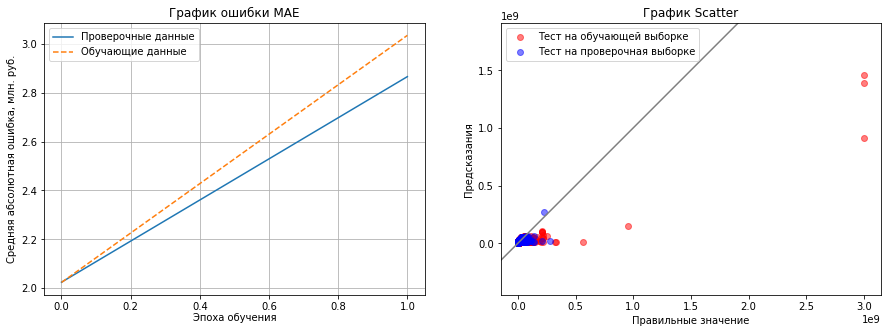



Эпоха 2
            Модуль ошибки на проверочной выборке: 1.702 млн. руб.
              Модуль ошибки на обучающей выборке: 1.553 млн. руб.

                         Время обучения на эпохе: 17.9 сек.
                Прошло времени с начала обучения: 49.8 сек.
        Прогоноз времени оставшегося на обучение: 448.5 сек.

                   learning_rate последней эпохи: 0.001




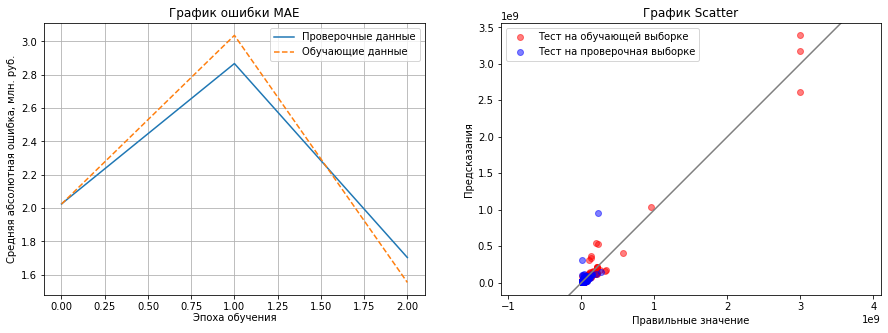



Эпоха 3
            Модуль ошибки на проверочной выборке: 1.52 млн. руб.
              Модуль ошибки на обучающей выборке: 1.498 млн. руб.

                         Время обучения на эпохе: 16.0 сек.
                Прошло времени с начала обучения: 65.9 сек.
        Прогоноз времени оставшегося на обучение: 428.0 сек.

                   learning_rate последней эпохи: 0.001




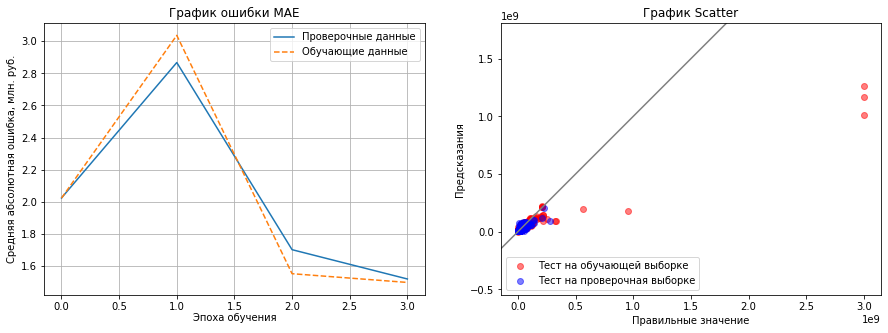



Эпоха 4
            Модуль ошибки на проверочной выборке: 2.304 млн. руб.
              Модуль ошибки на обучающей выборке: 2.271 млн. руб.

                         Время обучения на эпохе: 17.5 сек.
                Прошло времени с начала обучения: 83.4 сек.
        Прогоноз времени оставшегося на обучение: 416.8 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.4750178861
                 Среднее mae за последние 5 эпох: 2.0832138472
Относительное отклонение mae за последние 5 эпох: 22.802 %



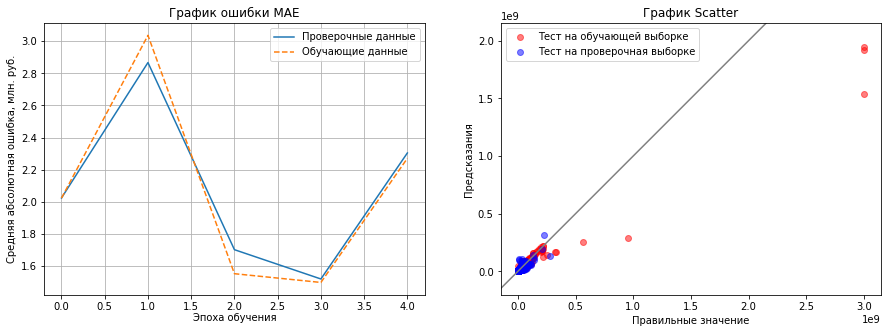



Эпоха 5
            Модуль ошибки на проверочной выборке: 1.593 млн. руб.
              Модуль ошибки на обучающей выборке: 1.558 млн. руб.

                         Время обучения на эпохе: 18.2 сек.
                Прошло времени с начала обучения: 101.5 сек.
        Прогоноз времени оставшегося на обучение: 406.0 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.5154053815
                 Среднее mae за последние 5 эпох: 1.9969502379
Относительное отклонение mae за последние 5 эпох: 25.81 %



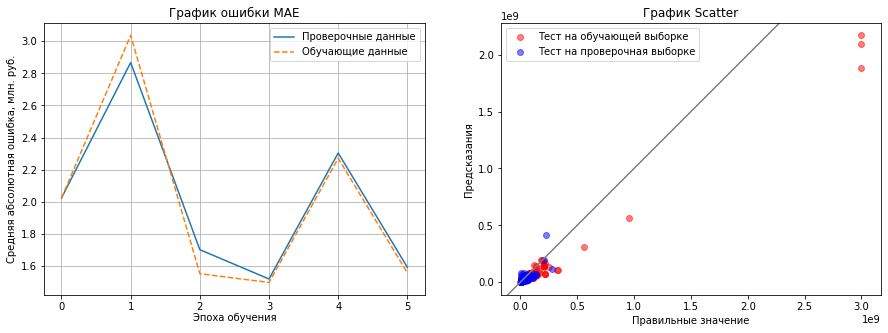



Эпоха 6
            Модуль ошибки на проверочной выборке: 1.446 млн. руб.
              Модуль ошибки на обучающей выборке: 1.227 млн. руб.

                         Время обучения на эпохе: 15.9 сек.
                Прошло времени с начала обучения: 117.4 сек.
        Прогоноз времени оставшегося на обучение: 385.7 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.3073194256
                 Среднее mae за последние 5 эпох: 1.7128738864
Относительное отклонение mae за последние 5 эпох: 17.942 %



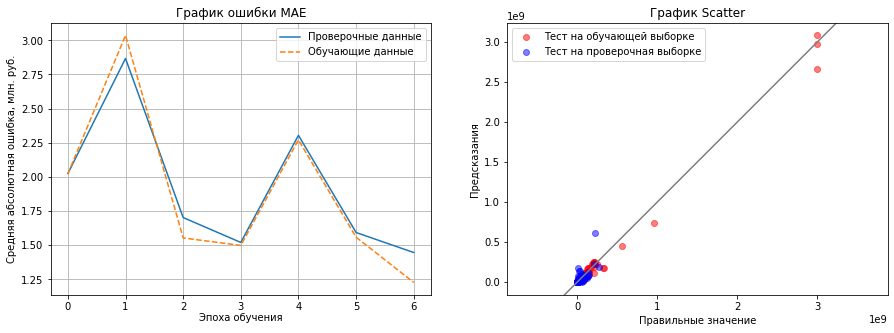



Эпоха 7
            Модуль ошибки на проверочной выборке: 1.227 млн. руб.
              Модуль ошибки на обучающей выборке: 0.985 млн. руб.

                         Время обучения на эпохе: 16.2 сек.
                Прошло времени с начала обучения: 133.5 сек.
        Прогоноз времени оставшегося на обучение: 367.2 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.3642501777
                 Среднее mae за последние 5 эпох: 1.6177576573
Относительное отклонение mae за последние 5 эпох: 22.516 %



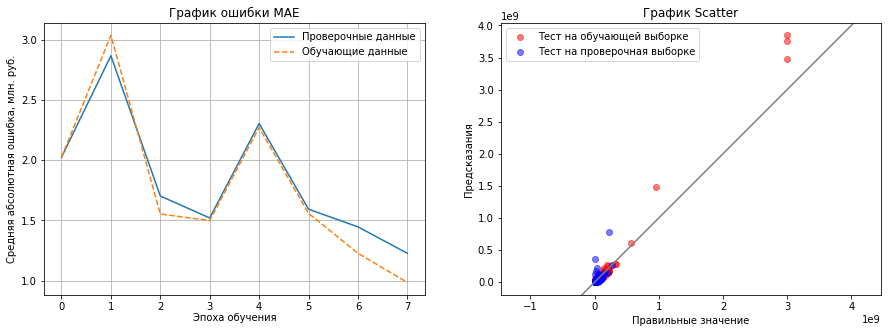



Эпоха 8
            Модуль ошибки на проверочной выборке: 2.404 млн. руб.
              Модуль ошибки на обучающей выборке: 2.245 млн. руб.

                         Время обучения на эпохе: 17.6 сек.
                Прошло времени с начала обучения: 151.1 сек.
        Прогоноз времени оставшегося на обучение: 352.6 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.4724644968
                 Среднее mae за последние 5 эпох: 1.7946683351
Относительное отклонение mae за последние 5 эпох: 26.326 %



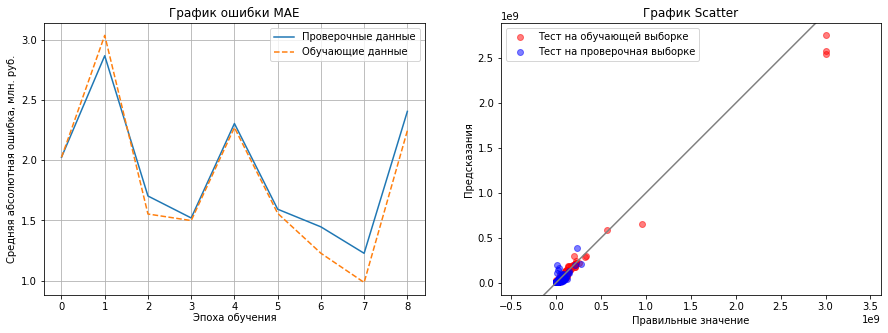



Эпоха 9
            Модуль ошибки на проверочной выборке: 1.149 млн. руб.
              Модуль ошибки на обучающей выборке: 0.874 млн. руб.

                         Время обучения на эпохе: 18.1 сек.
                Прошло времени с начала обучения: 169.2 сек.
        Прогоноз времени оставшегося на обучение: 338.5 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.4487106783
                 Среднее mae за последние 5 эпох: 1.5638042211
Относительное отклонение mae за последние 5 эпох: 28.694 %



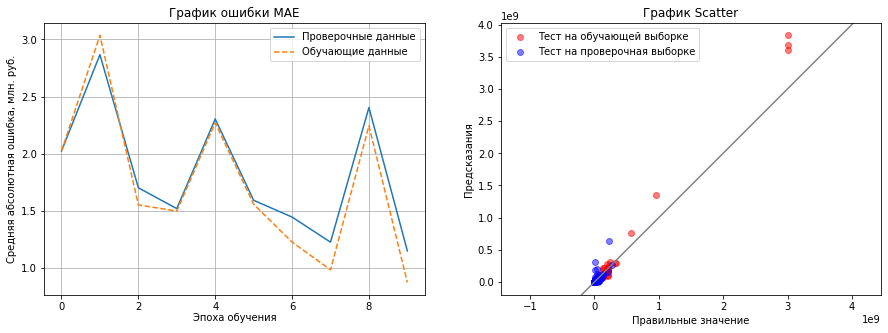



Эпоха 10
            Модуль ошибки на проверочной выборке: 2.225 млн. руб.
              Модуль ошибки на обучающей выборке: 2.034 млн. руб.

                         Время обучения на эпохе: 18.2 сек.
                Прошло времени с начала обучения: 187.4 сек.
        Прогоноз времени оставшегося на обучение: 323.7 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.52212567
                 Среднее mae за последние 5 эпох: 1.6902919222
Относительное отклонение mae за последние 5 эпох: 30.89 %



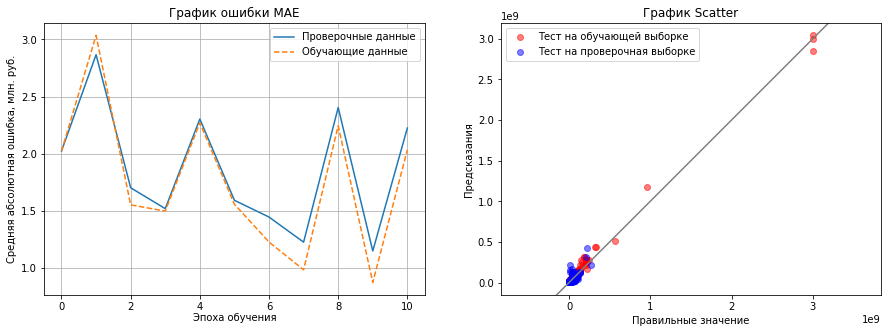



Эпоха 11
            Модуль ошибки на проверочной выборке: 1.056 млн. руб.
              Модуль ошибки на обучающей выборке: 0.783 млн. руб.

                         Время обучения на эпохе: 16.2 сек.
                Прошло времени с начала обучения: 203.6 сек.
        Прогоноз времени оставшегося на обучение: 305.4 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.5788580475
                 Среднее mae за последние 5 эпох: 1.61227145
Относительное отклонение mae за последние 5 эпох: 35.903 %



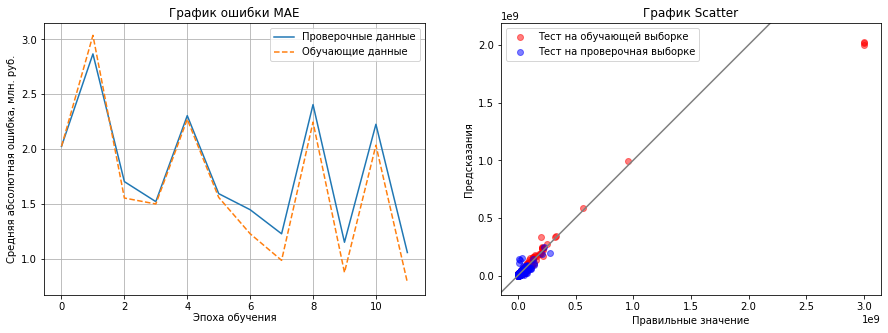



Эпоха 12
            Модуль ошибки на проверочной выборке: 1.112 млн. руб.
              Модуль ошибки на обучающей выборке: 0.836 млн. руб.

                         Время обучения на эпохе: 18.3 сек.
                Прошло времени с начала обучения: 221.9 сек.
        Прогоноз времени оставшегося на обучение: 290.1 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.5957650857
                 Среднее mae за последние 5 эпох: 1.5892714707
Относительное отклонение mae за последние 5 эпох: 37.487 %



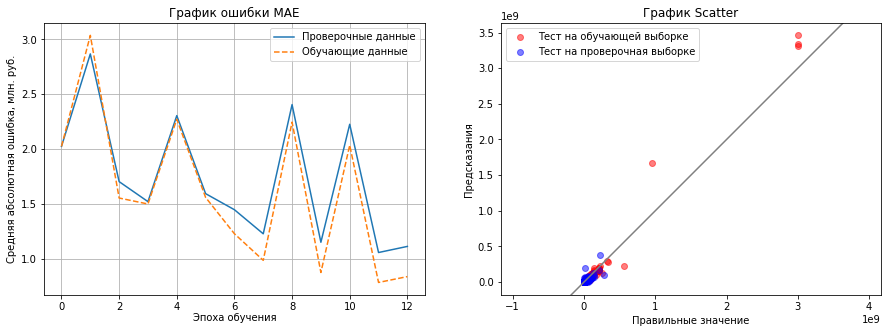



Эпоха 13
            Модуль ошибки на проверочной выборке: 1.067 млн. руб.
              Модуль ошибки на обучающей выборке: 0.827 млн. руб.

                         Время обучения на эпохе: 17.2 сек.
                Прошло времени с начала обучения: 239.1 сек.
        Прогоноз времени оставшегося на обучение: 273.3 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.4528279528
                 Среднее mae за последние 5 эпох: 1.3218051808
Относительное отклонение mae за последние 5 эпох: 34.258 %



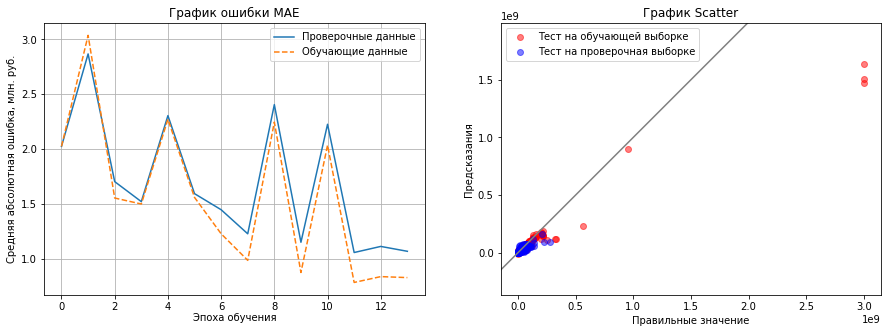



Эпоха 14
            Модуль ошибки на проверочной выборке: 1.067 млн. руб.
              Модуль ошибки на обучающей выборке: 0.733 млн. руб.

                         Время обучения на эпохе: 18.1 сек.
                Прошло времени с начала обучения: 257.2 сек.
        Прогоноз времени оставшегося на обучение: 257.2 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.4602012928
                 Среднее mae за последние 5 эпох: 1.3053977872
Относительное отклонение mae за последние 5 эпох: 35.254 %



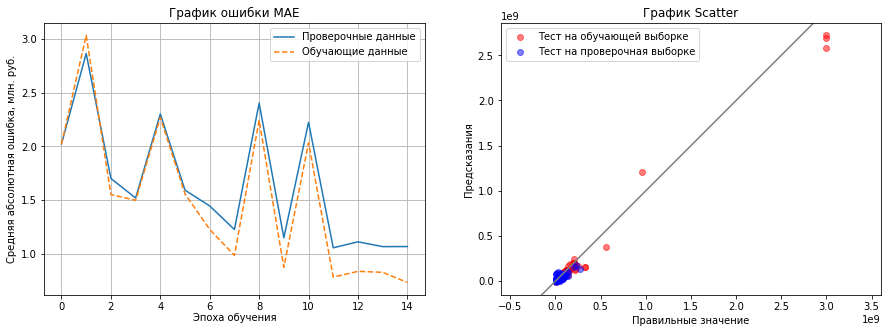



Эпоха 15
            Модуль ошибки на проверочной выборке: 1.038 млн. руб.
              Модуль ошибки на обучающей выборке: 0.715 млн. руб.

                         Время обучения на эпохе: 22.9 сек.
                Прошло времени с начала обучения: 280.1 сек.
        Прогоноз времени оставшегося на обучение: 245.1 сек.

                   learning_rate последней эпохи: 0.001
   Стандартное отклоение mae за последние 5 эпох: 0.0243021823
                 Среднее mae за последние 5 эпох: 1.0679618677
Относительное отклонение mae за последние 5 эпох: 2.276 %

      Корректируем learning_rate, новое значение: 0.0001 



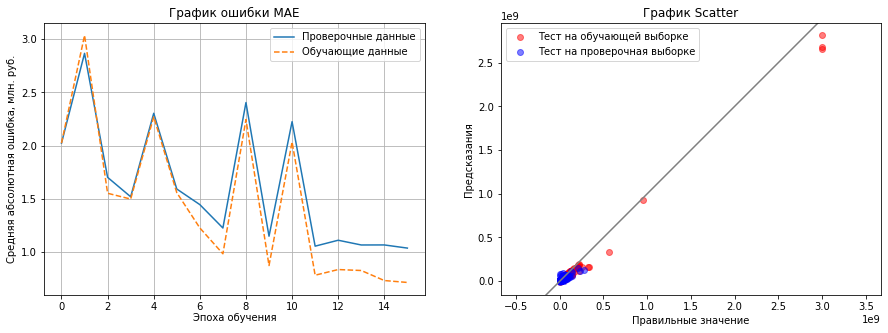



Эпоха 16
            Модуль ошибки на проверочной выборке: 1.109 млн. руб.
              Модуль ошибки на обучающей выборке: 0.759 млн. руб.

                         Время обучения на эпохе: 16.9 сек.
                Прошло времени с начала обучения: 296.9 сек.
        Прогоноз времени оставшегося на обучение: 227.1 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0280291211
                 Среднее mae за последние 5 эпох: 1.0785687849
Относительное отклонение mae за последние 5 эпох: 2.599 %



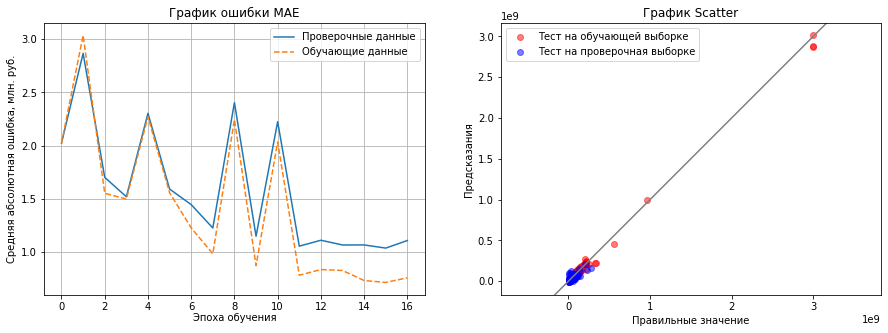



Эпоха 17
            Модуль ошибки на проверочной выборке: 0.988 млн. руб.
              Модуль ошибки на обучающей выборке: 0.586 млн. руб.

                         Время обучения на эпохе: 17.9 сек.
                Прошло времени с начала обучения: 314.9 сек.
        Прогоноз времени оставшегося на обучение: 209.9 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0399269768
                 Среднее mae за последние 5 эпох: 1.053890063
Относительное отклонение mae за последние 5 эпох: 3.789 %



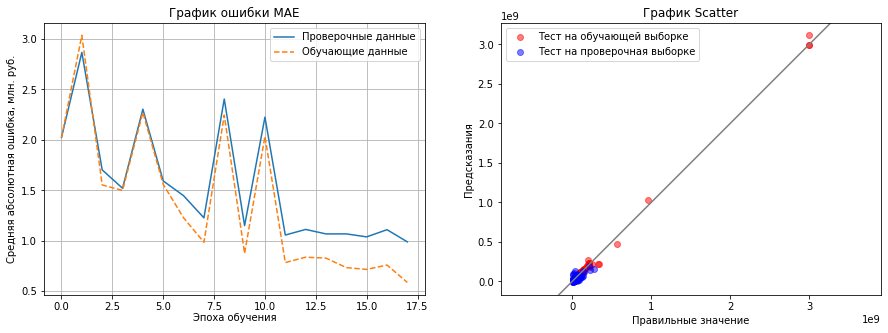



Эпоха 18
            Модуль ошибки на проверочной выборке: 0.987 млн. руб.
              Модуль ошибки на обучающей выборке: 0.577 млн. руб.

                         Время обучения на эпохе: 15.7 сек.
                Прошло времени с начала обучения: 330.6 сек.
        Прогоноз времени оставшегося на обучение: 191.4 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.046810854
                 Среднее mae за последние 5 эпох: 1.0379430867
Относительное отклонение mae за последние 5 эпох: 4.51 %



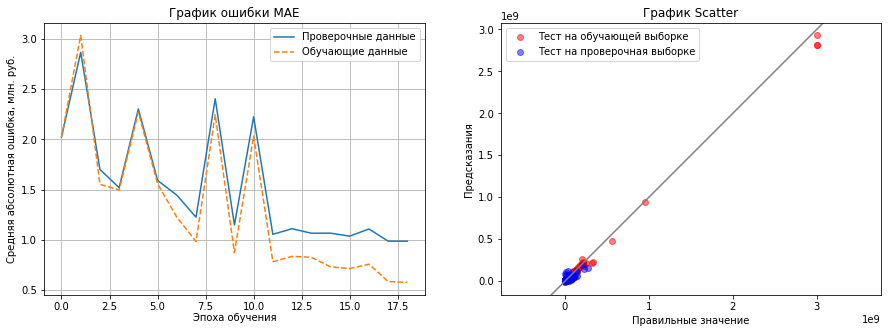



Эпоха 19
            Модуль ошибки на проверочной выборке: 0.964 млн. руб.
              Модуль ошибки на обучающей выборке: 0.531 млн. руб.

                         Время обучения на эпохе: 17.3 сек.
                Прошло времени с начала обучения: 347.9 сек.
        Прогоноз времени оставшегося на обучение: 173.9 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0518268724
                 Среднее mae за последние 5 эпох: 1.0172286714
Относительное отклонение mae за последние 5 эпох: 5.095 %



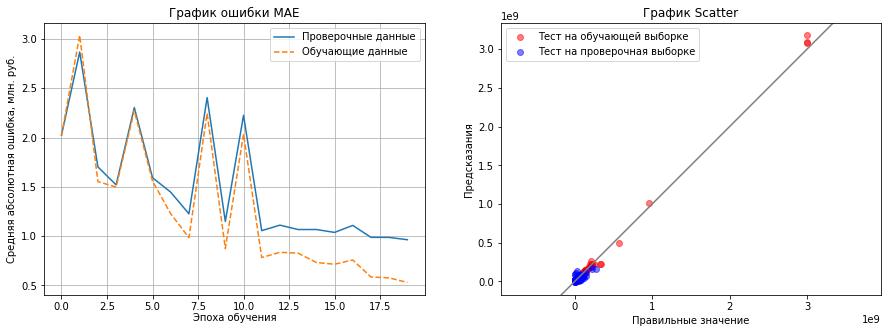



Эпоха 20
            Модуль ошибки на проверочной выборке: 0.98 млн. руб.
              Модуль ошибки на обучающей выборке: 0.536 млн. руб.

                         Время обучения на эпохе: 16.3 сек.
                Прошло времени с начала обучения: 364.2 сек.
        Прогоноз времени оставшегося на обучение: 156.1 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0524057041
                 Среднее mae за последние 5 эпох: 1.0056276817
Относительное отклонение mae за последние 5 эпох: 5.211 %



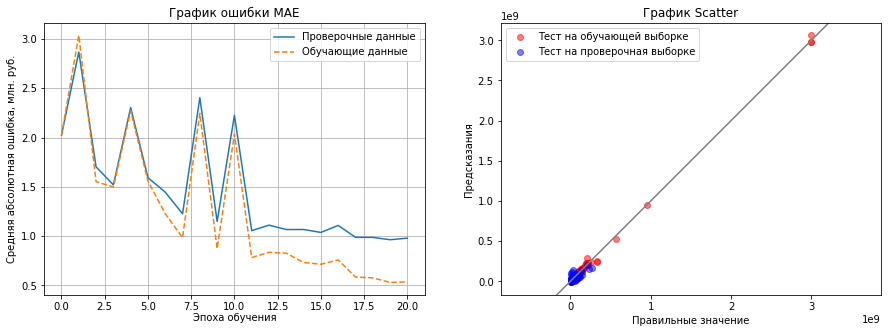



Эпоха 21
            Модуль ошибки на проверочной выборке: 0.956 млн. руб.
              Модуль ошибки на обучающей выборке: 0.497 млн. руб.

                         Время обучения на эпохе: 17.9 сек.
                Прошло времени с начала обучения: 382.1 сек.
        Прогоноз времени оставшегося на обучение: 138.9 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0128295438
                 Среднее mae за последние 5 эпох: 0.9750873272
Относительное отклонение mae за последние 5 эпох: 1.316 %



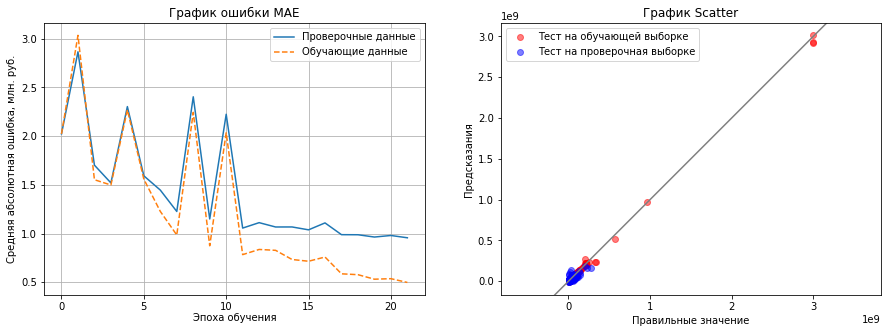



Эпоха 22
            Модуль ошибки на проверочной выборке: 1.037 млн. руб.
              Модуль ошибки на обучающей выборке: 0.619 млн. руб.

                         Время обучения на эпохе: 16.2 сек.
                Прошло времени с начала обучения: 398.3 сек.
        Прогоноз времени оставшегося на обучение: 121.2 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0283690033
                 Среднее mae за последние 5 эпох: 0.9848871936
Относительное отклонение mae за последние 5 эпох: 2.88 %



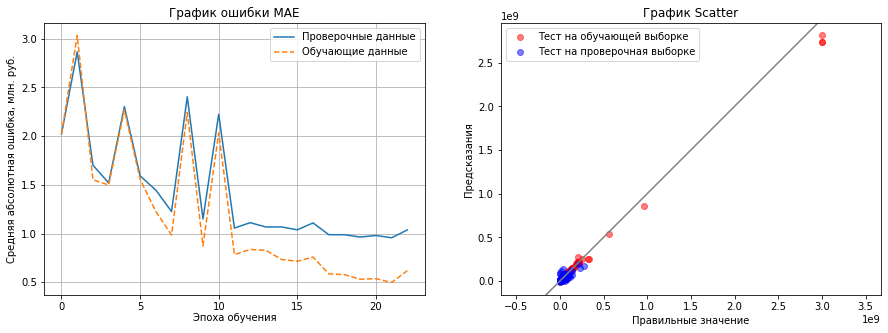



Эпоха 23
            Модуль ошибки на проверочной выборке: 0.943 млн. руб.
              Модуль ошибки на обучающей выборке: 0.472 млн. руб.

                         Время обучения на эпохе: 17.8 сек.
                Прошло времени с начала обучения: 416.0 сек.
        Прогоноз времени оставшегося на обучение: 104.0 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0328929781
                 Среднее mae за последние 5 эпох: 0.9759307932
Относительное отклонение mae за последние 5 эпох: 3.37 %



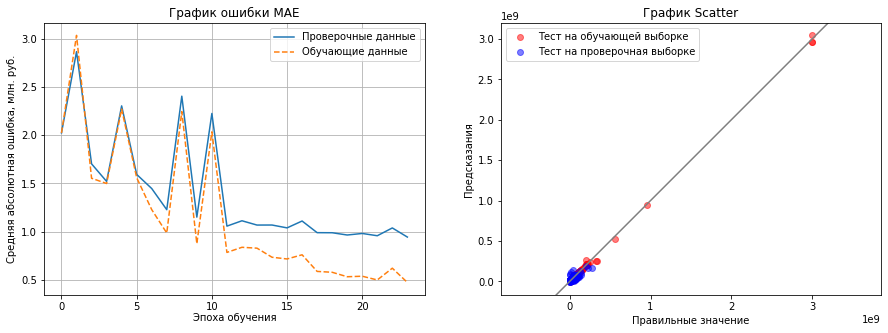



Эпоха 24
            Модуль ошибки на проверочной выборке: 0.947 млн. руб.
              Модуль ошибки на обучающей выборке: 0.475 млн. руб.

                         Время обучения на эпохе: 16.5 сек.
                Прошло времени с начала обучения: 432.6 сек.
        Прогоноз времени оставшегося на обучение: 86.5 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0347971888
                 Среднее mae за последние 5 эпох: 0.9725199727
Относительное отклонение mae за последние 5 эпох: 3.578 %



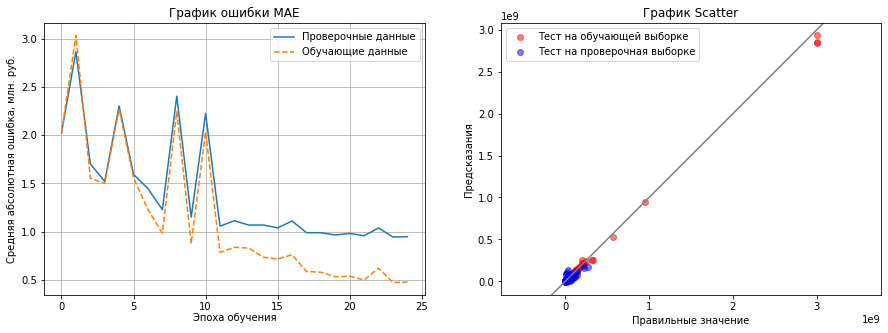



Эпоха 25
            Модуль ошибки на проверочной выборке: 0.937 млн. руб.
              Модуль ошибки на обучающей выборке: 0.457 млн. руб.

                         Время обучения на эпохе: 16.3 сек.
                Прошло времени с начала обучения: 448.9 сек.
        Прогоноз времени оставшегося на обучение: 69.1 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0371495316
                 Среднее mae за последние 5 эпох: 0.9639374159
Относительное отклонение mae за последние 5 эпох: 3.854 %



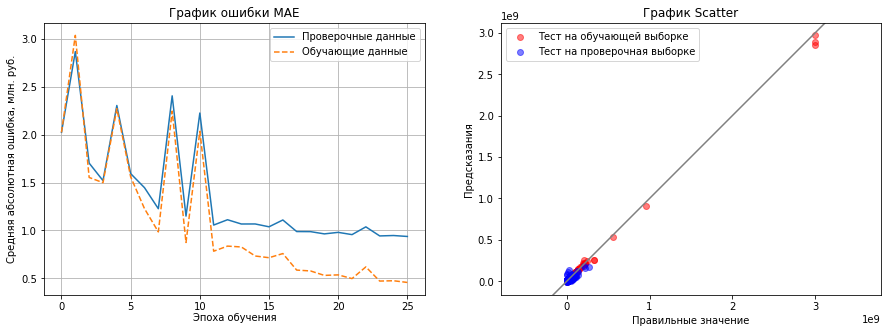



Эпоха 26
            Модуль ошибки на проверочной выборке: 0.95 млн. руб.
              Модуль ошибки на обучающей выборке: 0.471 млн. руб.

                         Время обучения на эпохе: 15.8 сек.
                Прошло времени с начала обучения: 464.7 сек.
        Прогоноз времени оставшегося на обучение: 51.6 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0375199071
                 Среднее mae за последние 5 эпох: 0.9625998322
Относительное отклонение mae за последние 5 эпох: 3.898 %



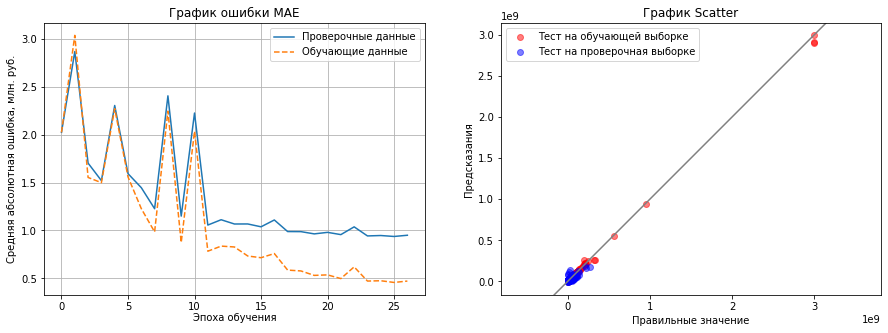



Эпоха 27
            Модуль ошибки на проверочной выборке: 0.982 млн. руб.
              Модуль ошибки на обучающей выборке: 0.522 млн. руб.

                         Время обучения на эпохе: 16.4 сек.
                Прошло времени с начала обучения: 481.1 сек.
        Прогоноз времени оставшегося на обучение: 34.4 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0157738532
                 Среднее mae за последние 5 эпох: 0.9515537414
Относительное отклонение mae за последние 5 эпох: 1.658 %



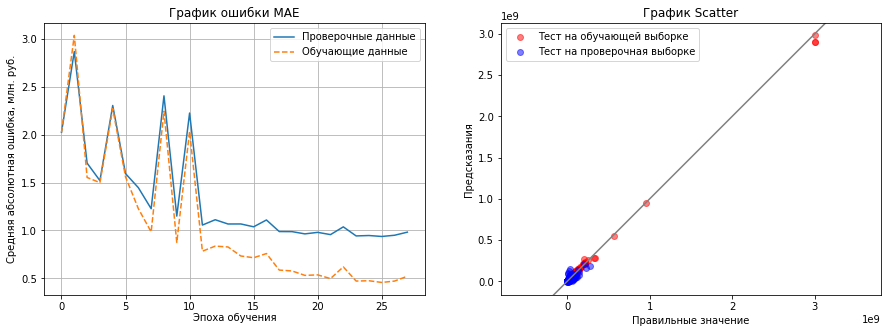



Эпоха 28
            Модуль ошибки на проверочной выборке: 0.947 млн. руб.
              Модуль ошибки на обучающей выборке: 0.465 млн. руб.

                         Время обучения на эпохе: 17.4 сек.
                Прошло времени с начала обучения: 498.5 сек.
        Прогоноз времени оставшегося на обучение: 17.2 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.0153747803
                 Среднее mae за последние 5 эпох: 0.9524043948
Относительное отклонение mae за последние 5 эпох: 1.614 %



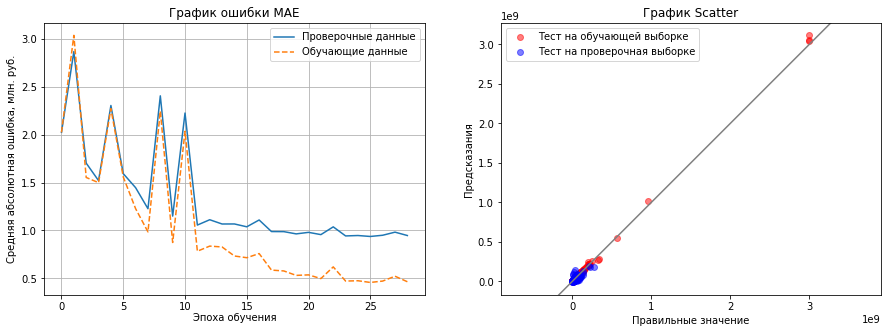



Эпоха 29
            Модуль ошибки на проверочной выборке: 0.939 млн. руб.
              Модуль ошибки на обучающей выборке: 0.451 млн. руб.

                         Время обучения на эпохе: 16.2 сек.
                Прошло времени с начала обучения: 514.8 сек.
        Прогоноз времени оставшегося на обучение: 0.0 сек.

                   learning_rate последней эпохи: 0.0001
   Стандартное отклоение mae за последние 5 эпох: 0.016185112
                 Среднее mae за последние 5 эпох: 0.9509143174
Относительное отклонение mae за последние 5 эпох: 1.702 %



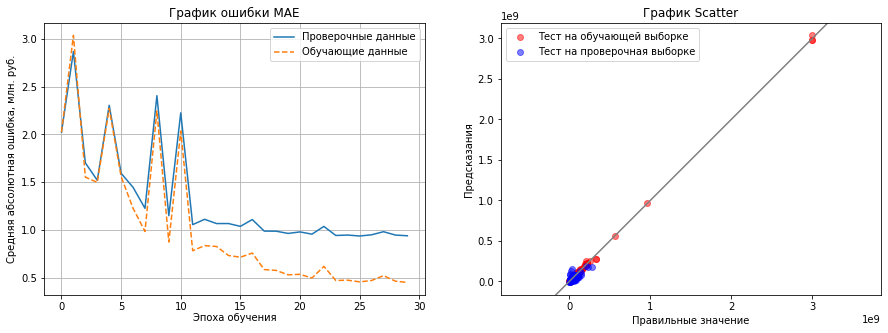



Сеть показала лучшие результаты на 25 эпохе


In [26]:
# Обучаем сеть с кастомным колбэком
# Накопление данных в колбеке сбрасывается пересозднанием объекта колбека, выше через одну ячейку (там же где объявляется класс CustomCallback)

history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=30, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose = 0,
                    callbacks = [my_call_back])

In [27]:
# Сохряняем сеть с лучшей точностью в h5 файл 

model.set_weights(my_call_back.best_weights)       # Загружаем в сеть лучшие веса

model.save_weights('model.h5')          # Сохраняем в файл